In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.cluster import MeanShift, estimate_bandwidth

In [16]:
# считывает csv файл и преобразует его к более сжатому виду
def read(name):
    colnames=['Ind', 'Time', 'Z', 'Temp', 'Pulse', '1', '2', 'O1', 'O2', '3', '4', '5', '6', '7', 'R1', 'R2', '8', '9'] 
    df = pd.read_csv(name, header=None, names=colnames, delimiter=';')
    # удаляем полностью пустые колонки
    df.dropna(axis='columns', how='all', inplace=True)
    df['Time'] = df['Time'].str.replace(',', '').astype('int64')

    # объединяем ассинхронные записи в одну с помощью алгоритма Mean Shift
    array = np.vstack((df['Time'].to_numpy(), df['Ind'].to_numpy())).T
    bandwidth = estimate_bandwidth(array, quantile=3.8/len(array)+0.00085, n_samples=len(array))
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(array)
    labels = ms.labels_

    # объединяем записи согласно полученной кластеризации
    # заметим, что кластер может состоять только из подряд идущих записей
    # таким образом объединяем записи
    colnames_new = list(df.columns)
    df_new = df.drop(df.index)

    cur_label = -1
    cur_row = []
    cur_num = []

    for i in range(0, len(labels)):
        if (labels[i] != cur_label):
            if (cur_label != -1):
                for j in range(1, len(cur_row)):
                    if (cur_num[j] != 0):
                        cur_row[j] /= cur_num[j]
                df_new.loc[len(df_new)] = cur_row

            cur_label = labels[i]
            cur_row = df.iloc[[array[i][1]]].to_numpy()[0]
            cur_row[np.isnan(cur_row)] = 0
            cur_num = np.zeros(len(cur_row))
            for j in range(len(cur_row)):
                if (cur_row[j] > 0):
                    cur_num[j] = 1
        else:
            tmp_row = df.iloc[[array[i][1]]].to_numpy()[0]
            tmp_row[np.isnan(tmp_row)] = 0
            for j in range(1, len(tmp_row)):
                if (tmp_row[j] > 0):
                    cur_num[j] += 1
                    cur_row[j] += tmp_row[j]
    if (cur_label != -1):
            for j in range(1, len(cur_row)):
                if (cur_num[j] != 0):
                    cur_row[j] /= cur_num[j]
            df_new.loc[len(df_new)] = cur_row

    df = df_new
    return df

In [17]:
X = [[], []]
Y = []

for filename in os.listdir("Data/Anxienty"):
    df = read('Data/Anxienty/' + filename)
    # собираем данные для обучения
    # для создания обучающей выборки было решено использовать показатели температуры и электрической активности кожи, 
    # пульс было решено не использовать, так как этот показатель часто отсутствует в записях. Для формирования выборки мы прошлись некоторым окном, 
    # разделенным на 3 части, по записям и сравнили средние значения температуры и электрической активности кожи в центральной части окна и боковых частях, 
    # если эти показатели в центральной части выше, можно сделать вывод о некотором локальном максимуме в центральной части, а значит о стрессе в этот момент времени. 
    # Такие моменты времени помечаем как 1.
    window_size = 5
    result = [0] * len(df)
    for i in range(len(df) - 3 * window_size):
        left_block = [df.iloc[i:i+window_size]['Temp'].mean(), df.iloc[i:i+window_size]['Z'].mean()]
        medi_block = [df.iloc[i+window_size:i+2*window_size]['Temp'].mean(), df.iloc[i+window_size:i+2*window_size]['Z'].mean()]
        righ_block = [df.iloc[i+2*window_size:i+3*window_size]['Temp'].mean(), df.iloc[i+2*window_size:i+3*window_size]['Z'].mean()]
        if (medi_block[0] > left_block[0] and medi_block[0] > righ_block[0] and medi_block[1] > left_block[1] and medi_block[1] > righ_block[1]):
            for j in range(i+window_size, i+2*window_size):
                result[j] = 1
    X[0].extend(df['Temp'].tolist())
    X[1].extend(df['Z'].tolist())
    Y.extend(result)

# в векторе Х: x_i - пара (температура; электрическая активность кожи)
# в векторе Y: y_i - истина или ложь; истина, если запись принадлежит к эпизоду тревожности, в противном случае ложь
X = np.array(X).T
Y = np.array(Y)

# выборка получилась неравномерной, то есть количество элементом с ложью превышает количество элементов с истиной, 
# поэтому необходимо искусственно дополнить выборку элементами с истиной (продублировать имеющиеся)
zer = 0
for i in range(len(Y)):
    zer += Y[i] == 0

N = len(Y)

for i in range(N):
    if (Y[i]):
        for j in range(zer // (N - zer) - 2):
            X = np.concatenate((X, X[i].reshape(1, 2)), axis=0)
            Y = np.append(Y, Y[i])

In [18]:
# обучение модели
logr = linear_model.LogisticRegression()
logr.fit(X,Y)
 
df = read('Data/50a8437b-1390-4b3a-a8c1-6dcdd15769ba/2022.02.18 23-00-00.csv')

New_X = [[], []]
New_X[0].extend(df['Temp'].tolist())
New_X[1].extend(df['Z'].tolist())
New_X = np.array(New_X).T

# получение предсказания
predicted = logr.predict(New_X)

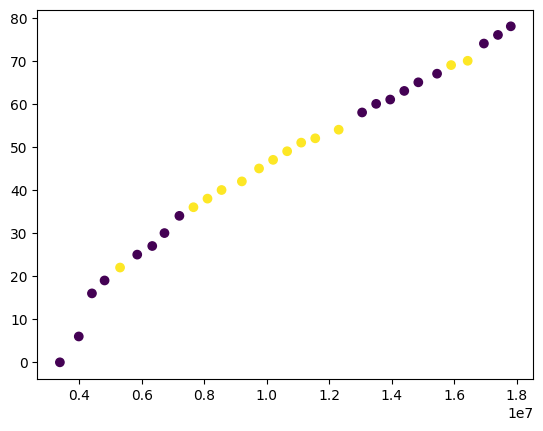

In [19]:
# график, отображающий тревожные моменты
# ось ОХ - время, OY - наличие записи
# желтые точки - тревожность, фиолетовые - не тревожность
plt.scatter(df['Time'].iloc[0:30], df['Ind'].iloc[0:30], c=predicted[0:30])

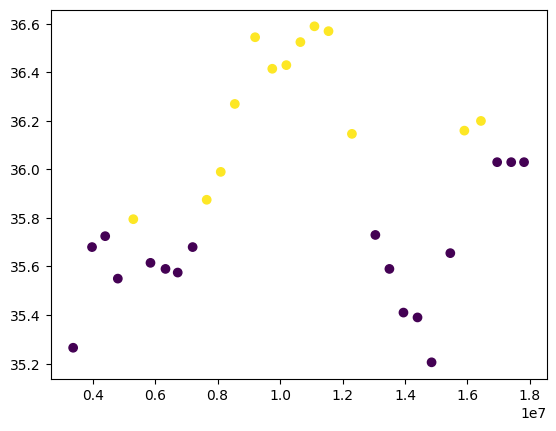

In [20]:
# здесь OX - время, OY - температуре тела
# желтые точки - тревожность, фиолетовые - не тревожность
plt.scatter(df['Time'].iloc[0:30], df['Temp'].iloc[0:30], c=predicted[0:30])

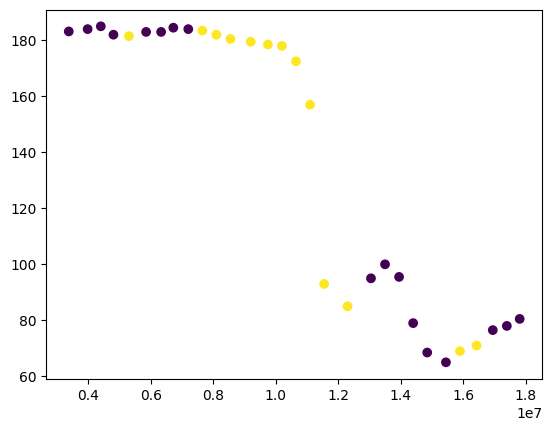

In [21]:
# здесь OX - время, OY - электрическая активность кожи
# желтые точки - тревожность, фиолетовые - не тревожность
plt.scatter(df['Time'].iloc[0:30], df['Z'].iloc[0:30], c=predicted[0:30])